In [1]:
import sys; sys.path.append('../../utils')
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid')

from utils import save_plot

In [2]:
MONK_TASK = 1

In [3]:
TRAIN_DATA = os.path.join('..', '..', '..', 'datasets', 'monk', f'monks-{MONK_TASK}.train')
TEST_DATA = os.path.join('..', '..', '..', 'datasets', 'monk', f'monks-{MONK_TASK}.test')
IMAGES_FOLDER = os.path.join('..', '..', '..', 'images', 'monk', f'task-{MONK_TASK}', 'neural_network')
MODEL_FOLDER = os.path.join('..', '..', '..', 'trained_models', 'monk', f'task-{MONK_TASK}')

In [4]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 8))

df_train = pd.read_csv(TRAIN_DATA, header=None, usecols=columns_to_read, delimiter=' ')
df_test = pd.read_csv(TEST_DATA, header=None, usecols=columns_to_read, delimiter=' ')
df_train.head()

,1,2,3,4,5,6,7
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1


In [5]:
features = ['feature_' + str(i) for i in range(1, 7)]

# Rename columns
new_column_names = ['class'] + features

df_train.columns = new_column_names
df_test.columns = new_column_names

df_train.head()

,class,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1


In [6]:
df_train_encoded = pd.get_dummies(df_train, columns=features)
df_test_encoded = pd.get_dummies(df_test, columns=features)

df_train_encoded, df_test_encoded = df_train_encoded.align(df_test_encoded, join='inner', axis=1)

df_train_encoded.head()

,class,feature_1_1,feature_1_2,feature_1_3,feature_2_1,feature_2_2,feature_2_3,feature_3_1,feature_3_2,feature_4_1,feature_4_2,feature_4_3,feature_5_1,feature_5_2,feature_5_3,feature_5_4,feature_6_1,feature_6_2
0,1,True,False,False,True,False,False,True,False,True,False,False,False,False,True,False,True,False
1,1,True,False,False,True,False,False,True,False,True,False,False,False,False,True,False,False,True
2,1,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False
3,1,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,True
4,1,True,False,False,True,False,False,False,True,True,False,False,False,True,False,False,True,False


In [7]:
features = df_train_encoded.columns.difference(['class'])

X_train = df_train_encoded[features].to_numpy()
y_train = df_train_encoded['class'].to_numpy()

X_test = df_test_encoded[features].to_numpy()
y_test = df_test_encoded['class'].to_numpy()

# Create model

In [8]:
from keras.src.layers import Dropout
from keras.src.constraints import MaxNorm
from keras.src.initializers.initializers import HeNormal
from keras.src.callbacks import EarlyStopping
from keras.src.optimizers import Adam, SGD
from keras.models import Sequential
from keras.layers import Dense

def create_model(architecture=(8,), optimizer='adam', learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units=architecture[0], input_dim=X_train.shape[1], activation='relu',
                        kernel_initializer=HeNormal(), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))

    for units in architecture[1:]:
        model.add(Dense(units=units, activation='relu',
                        kernel_initializer=HeNormal(), kernel_constraint=MaxNorm(3)))
        model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

/Users/paolomollica/Projects/data-spell-projects/machine-learning-project/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [9]:
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

model = KerasClassifier(create_model, verbose=0)

pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('neuralnetwork', model)
])

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'neuralnetwork__model__architecture': [
        (16, 16), (32, 16), (32, 32), (64, 32)
    ],
    'neuralnetwork__model__optimizer': ['sgd'],
    'neuralnetwork__model__learning_rate': [0.1, 0.01],
    'neuralnetwork__epochs': [20, 50],
    'neuralnetwork__batch_size': [8, 16]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/paolomollica/Projects/data-spell-projects/machine-learning-project/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/paolomollica/Projects/data-spell-projects/machine-learning-project/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/paolomollica/Projects/data-spell-projects/machine-learning-project/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/paolomollica/Projects/data-

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('neuralnetwork',
                                        KerasClassifier(model=<function create_model at 0x165160310>, verbose=0))]),
             n_jobs=-1,
             param_grid={'neuralnetwork__batch_size': [8, 16],
                         'neuralnetwork__epochs': [20, 50],
                         'neuralnetwork__model__architecture': [(16, 16),
                                                                (32, 16),
                                                                (32, 32),
                                                                (64, 32)],
                         'neuralnetwork__model__learning_rate': [0.1, 0.01],
                         'neuralnetwork__model__optimizer': ['sgd']},
             scoring='accuracy', verbose=2)

In [11]:
from sklearn.metrics import accuracy_score, classification_report

final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)

print('Best parameters: ', grid_search.best_params_)
print('Best accuracy: ', grid_search.best_score_)
print('Test set accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameters:  {'neuralnetwork__batch_size': 8, 'neuralnetwork__epochs': 20, 'neuralnetwork__model__architecture': (32, 32), 'neuralnetwork__model__learning_rate': 0.1, 'neuralnetwork__model__optimizer': 'sgd'}
Best accuracy:  0.6043333333333333
Test set accuracy:  0.6273148148148148
              precision    recall  f1-score   support

           0       0.67      0.50      0.58       216
           1       0.60      0.75      0.67       216

    accuracy                           0.63       432
   macro avg       0.64      0.63      0.62       432
weighted avg       0.64      0.63      0.62       432



# Learning curve

In [12]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=final_model,
    X=X_train,
    y=y_train,
    train_sizes=[0.1, 0.33, 0.55, 0.78, 1.],
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

[learning_curve] Training set sizes: [ 9 32 54 77 99]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:   11.1s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   18.0s finished


In [13]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

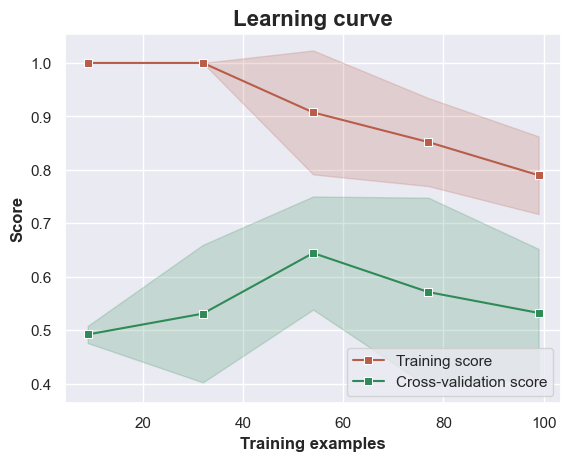

In [14]:
plt.figure()
plt.title('Learning curve', fontweight='bold', fontsize=16)
plt.xlabel('Training examples', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.grid(True)

color1 = sns.dark_palette((20, 60, 50), input='husl')[-1]
color2 = sns.dark_palette('seagreen')[-1]

# Filling the area around the mean scores to indicate variability of the model's performance
# The shaded area represents the range of scores (mean ± standard deviation) for each training set size
plt.fill_between(
    train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color=color1
)
plt.fill_between(
    train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2, color=color2
)

# Mean score lines for training and validation
sns.lineplot(x=train_sizes, y=train_scores_mean, marker='s', color=color1, label='Training score')
sns.lineplot(x=train_sizes, y=validation_scores_mean, marker='s', color=color2, label='Cross-validation score')

plt.legend(loc='lower right')

save_plot(plt, IMAGES_FOLDER, 'learning_curve')
plt.show()

# Save model

In [15]:
from joblib import dump

model_path = os.path.join(MODEL_FOLDER, 'NN_model.joblib')
dump(final_model, model_path, compress=3)

INFO:tensorflow:Assets written to: ram://8c217842662d4205be6fc27830658cda/assets


INFO:tensorflow:Assets written to: ram://8c217842662d4205be6fc27830658cda/assets


['../../../trained_models/monk/task-1/NN_model.joblib']